In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve,bicgstab
from scipy.interpolate import LinearNDInterpolator
import copy
import time
import pandas as pd
import solverFunctions as sf
import analysisFunctions as af
import os
import datetime
from tqdm import tqdm

In [15]:
order_bc = 5
u_d = np.load(r"DataDC/datasetDC_u_30_1_"+str(order_bc)+".npy")
v_d = np.load(r"DataDC/datasetDC_v_30_1_"+str(order_bc)+".npy")
p_d = np.load(r"DataDC/datasetDC_p_30_1_"+str(order_bc)+".npy")
# u_train = (u[:,1:,1:-1]+u[:,:-1,1:-1])/2
# u_train = np.expand_dims(u_train,axis=-1)
# v_train = (v[:,1:-1,1:]+v[:,1:-1,:-1])/2
# v_train = np.expand_dims(v_train,axis=-1)
# p_train = p
# p_train = np.expand_dims(p_train,axis=-1)
# x_train = np.concatenate([u_train,v_train,p_train],axis=3)
# print(x_train.shape)

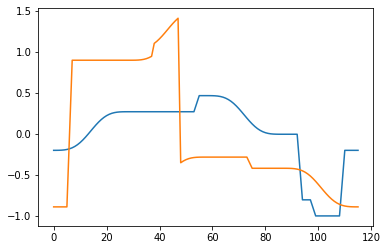

In [10]:
def GetBoundary(u,v):
    u_n = (u[:,1:]+u[:,:-1])/2
    v_n = (v[1:,:]+v[:-1,:])/2
    u_bc = np.concatenate([u_n[1:-1,0],u_n[-1,1:-1],u_n[1:-1,-1][::-1],u_n[0,1:-1][::-1]])
    v_bc = np.concatenate([v_n[1:-1,0],v_n[-1,1:-1],v_n[1:-1,-1][::-1],v_n[0,1:-1][::-1]])
    return u_bc,v_bc

i = 0
u_slice = u[i]
v_slice = v[i]
# u_slice = u
# v_slice = v

u_bc2,v_bc2=GetBoundary(u_slice,v_slice)
plt.plot(u_bc2)
plt.plot(v_bc2)


In [26]:
mp_e = prob.rho*prob.dy_p*u[:,1:,1:-1]
mp_w = prob.rho*prob.dy_p*u[:,:-1,1:-1]
mp_n = prob.rho*prob.dx_p*v[:,1:-1,1:]
mp_s = prob.rho*prob.dx_p*v[:,1:-1,:-1]
dmp = mp_w+mp_s-mp_e-mp_n
con_res = np.square(dmp).mean((1,2))
con_res

array([4.84078469e-15, 4.91706781e-15, 5.57728796e-16, 1.56845353e-15,
       9.27835614e-15, 4.48332742e-15, 9.74221301e-15, 1.35238199e-15,
       5.60634067e-17, 5.41319711e-15])

In [25]:
u=u_d[:10]
v=v_d[:10]
p=p_d[:10]
prob = sf.GetProblem(30,1)

In [19]:
mu_e = prob.rho*prob.dy_u*(u[1:-1,1:-1]+u[2:,1:-1])/2
mu_w = prob.rho*prob.dy_u*(u[:-2,1:-1]+u[1:-1,1:-1])/2
mu_n = prob.rho*prob.dx_u*(v[1:-2,1:]+v[2:-1,1:])/2
mu_s = prob.rho*prob.dx_u*(v[1:-2,:-1]+v[2:-1,:-1])/2
convection = -(mu_e*(u[2:,1:-1]+u[1:-1,1:-1])/2\
+ mu_n*(u[1:-1,2:]+u[1:-1,1:-1])/2\
- mu_w*(u[:-2,1:-1]+u[1:-1,1:-1])/2\
- mu_s*(u[1:-1,:-2]+u[1:-1,1:-1])/2)
diffusion = prob.Aud_x[:-1,:]*(u[1:-1,1:-1]-u[:-2,1:-1]) + prob.Aud_x[1:,:]*(u[1:-1,1:-1]-u[2:,1:-1]) +\
    prob.Aud_y[:,:-1]*(u[1:-1,1:-1]-u[1:-1,:-2]) + prob.Aud_y[:,1:]*(u[1:-1,1:-1]-u[1:-1,2:])
pressure = prob.dy_u*(p[1:,:]-p[:-1,:])
u_res = np.square(convection-diffusion-pressure).mean()
u_res

1.2769297236958748e-14

In [2]:
converged,u,v,p,prob,_ = sf.SolveCFD(30,1,i=1,order_bc = 2,continuous=False,alpha_uv = 0.5,alpha_p = 0.2,dif_tolerance=10**(-4),max_iterations=3000)

i=1; dif=9.876e-05; res=3.682e-15; itt=200		


In [27]:
u = np.zeros((4000,31,32))
v = np.zeros((4000,32,31))
p = np.zeros((4000,30,30))
indexes = []
index = 0
for i in range(4000):
    print('\r'+str(i),end="")
    try:
        u_slice = np.load(r"DataDC\Raw\dc_u_30_1_2_"+str(i)+".npy")
        u[index,:,:] = u_slice
        v_slice = np.load(r"DataDC\Raw\dc_v_30_1_2_"+str(i)+".npy")
        v[index,:,:] = v_slice
        p_slice = np.load(r"DataDC\Raw\dc_p_30_1_2_"+str(i)+".npy")
        p[index,:,:] = p_slice
        index+=1
        indexes.append(i)
    except:
        pass

u = u[:index,:,:]
v = v[:index,:,:]
p = p[:index,:,:]
print("\ndone")
print(u.shape)



3999
done
(3999, 31, 32)


In [114]:
order_bc=2
BCu = np.zeros((1000,4,32))
BCv = np.zeros((1000,4,32))
indexes = []
index = 0
for i in range(4000):
    print('\r'+str(i),end="")
    try:
        BCu_slice = np.load(r"DataDC\Raw\dc_BCu_30_1_"+str(order_bc)+"_"+str(i)+".npy")
        BCu[index,:,:] = BCu_slice
        BCv_slice = np.load(r"DataDC\Raw\dc_BCv_30_1_"+str(order_bc)+"_"+str(i)+".npy")
        BCv[index,:,:] = BCv_slice
        index+=1
        indexes.append[i]
    except:
        pass

BCu = BCu[:index,:,:]
BCv = BCv[:index,:,:]
print("\ndone")


3999
done


In [ ]:
n = 30
rho = 1
mu = 0.01
nx = ny = n
dt = 0.1
alpha_uv = 0.8
alpha_p = 0.4
CDS = True
order = 1

# BCu_slice = np.zeros((4,n+2))
# BCv_slice = np.zeros((4,n+2))
# BCu_slice[2,:] = 1
BCu_slice,BCv_slice,u_bc,v_bc,u_bc_cor,v_bc_cor = sf.GetBC2(x,order = 2,continuous=False)



x = sf.get1Dgrid(n+1,order)
y = x
prob = sf.CFDproblem(x,y, 1, 0.01, BCu_slice, BCv_slice,dt,alpha_uv,alpha_p,CDS)
u,v,p,log = sf.SolveProblem(prob,showProgress=True)
af.PlotConvergence(log)
af.PlotFlow(u,v,prob)

In [9]:
order_bc = 2
u = np.load(r"DataDC/datasetDC_u_30_1_"+str(order_bc)+".npy")
v = np.load(r"DataDC/datasetDC_v_30_1_"+str(order_bc)+".npy")
p = np.load(r"DataDC/datasetDC_p_30_1_"+str(order_bc)+".npy")

In [5]:
order_bc = 1
np.save(r"DataDC/datasetDC_u_30_1_"+str(order_bc)+".npy",u)
np.save(r"DataDC/datasetDC_v_30_1_"+str(order_bc)+".npy",v)
np.save(r"DataDC/datasetDC_p_30_1_"+str(order_bc)+".npy",p)

In [28]:
order_bc = 2
u_old = np.load(r"DataDC/datasetDC_u_30_1_"+str(order_bc)+".npy")
v_old = np.load(r"DataDC/datasetDC_v_30_1_"+str(order_bc)+".npy")
p_old = np.load(r"DataDC/datasetDC_p_30_1_"+str(order_bc)+".npy")

u = np.concatenate([u_old,u],axis=0)
v = np.concatenate([v_old,v],axis=0)
p = np.concatenate([p_old,p],axis=0)

np.save(r"DataDC/datasetDC_u_30_1_"+str(order_bc)+".npy",u)
np.save(r"DataDC/datasetDC_v_30_1_"+str(order_bc)+".npy",v)
np.save(r"DataDC/datasetDC_p_30_1_"+str(order_bc)+".npy",p)

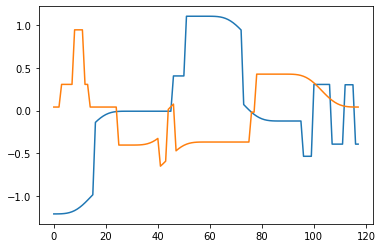

In [7]:
def BoundaryLine(BCu,BCv):
    u = np.concatenate([BCu[0,1:-2],BCu[3,1:-1],BCu[2,1:-2][::-1],BCu[1,1:-1][::-1]])
    v = np.concatenate([BCv[0,1:-1],BCv[3,1:-2],BCv[2,1:-1][::-1],BCv[1,1:-2][::-1]])
    return u,v

u,v = BoundaryLine(BCu[1],BCv[1])
plt.plot(u)
plt.plot(v)

100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


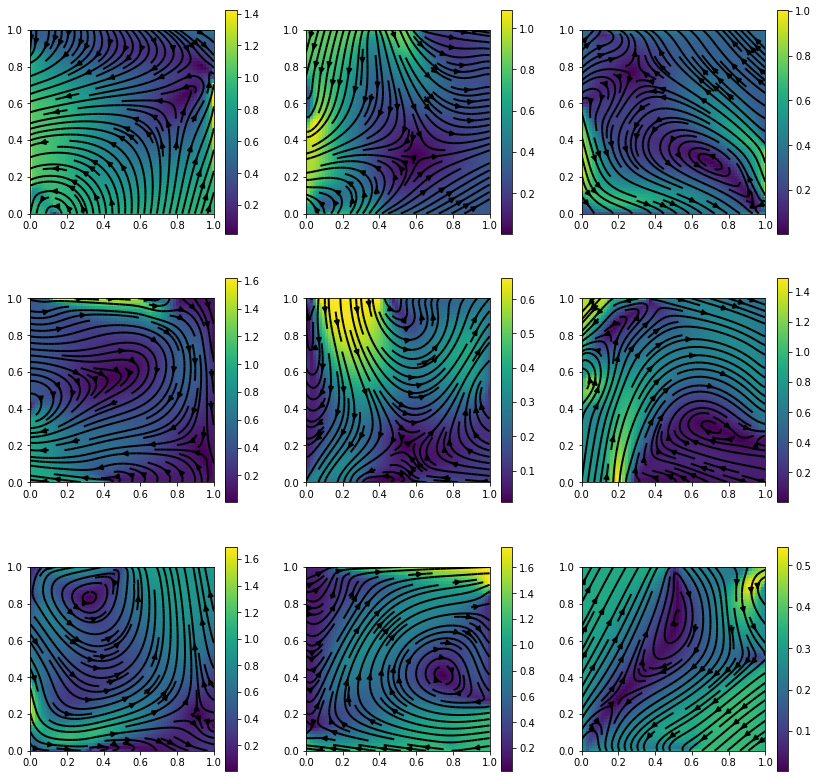

In [20]:
def SubplotFlow(a,b,u,v,prob):
    n = min(a*b,u.shape[0])
    plt.figure(figsize=(14,14))
    for i in tqdm(range(n)):
        X_n,Y_n = np.meshgrid(prob.xc_u,prob.yc_v)
        u_n = (u[i,:,:-1]+u[i,:,1:])/2
        v_n = (v[i,:-1,:]+v[i,1:,:])/2
        u_n = np.transpose(u_n)
        v_n = np.transpose(v_n)
        X,Y = np.meshgrid(np.linspace(0,1,u_n.shape[0]*2),np.linspace(0,1,u_n.shape[1]*2))
        points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
        values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
        interp = LinearNDInterpolator(points_n, values_n)
        values_i = interp(X,Y)
        u_c = values_i[:,:,0]
        v_c = values_i[:,:,1]
        ax = plt.subplot(a,b,i+1)
        ax.set_ylim([0,1])
        ax.set_xlim([0,1])
        c = ax.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
        plt.colorbar(c)
        ax.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
        plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def PlotX(a,b,x_train,prob):
    n = min(a*b,x_train.shape[0])
    plt.figure(figsize=(14,14))
    for i in tqdm(range(n)):
        X_n,Y_n = prob.X_p,prob.Y_p
        x_lim = (prob.xc_p[0],prob.xc_p[-1])
        y_lim = (prob.yc_p[0],prob.yc_p[-1])
        u_n = x_train[i,:,:,0]
        v_n = x_train[i,:,:,1]
        # u_n = np.transpose(u_n)
        # v_n = np.transpose(v_n)
        X,Y = np.meshgrid(np.linspace(x_lim[0],y_lim[-1],u_n.shape[0]*2),np.linspace(y_lim[0],y_lim[-1],u_n.shape[1]*2))
        points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
        values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
        interp = LinearNDInterpolator(points_n, values_n)
        values_i = interp(X,Y)
        u_c = values_i[:,:,0]
        v_c = values_i[:,:,1]
        ax = plt.subplot(a,b,i+1)
        ax.set_ylim(x_lim)
        ax.set_xlim(y_lim)
        c = ax.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
        plt.colorbar(c)
        ax.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
        plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

prob = sf.GetProblem(30,1)
SubplotFlow(3,3,u,v,prob)
# PlotX(3,3,x_train,prob)